In [229]:
# python 3.11.9

import os  
import OpenEXR
import Imath
import numpy as np
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import scipy.io
import time
import re 
torch.cuda.empty_cache()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, t_p_values, transform=None):
        self.images = images
        self.labels = labels
        self.t_p_values = t_p_values
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # shape should already be [1, H, W]
        label = self.labels[idx]
        t_p = self.t_p_values[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, t_p

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.size = embed_dim
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
  
  def __len__(self):
    return self.size

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        #self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        #self.camera_emb = GaussianFourierProjection(embed_dim=256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #self.fc1 = nn.Linear(64 * 25 * 25 , 512)  
        self.fc1 = nn.Linear(32 * 50 * 50 , 256)  
        self.ln1 = nn.LayerNorm(256)
        self.dropout1 = nn.Dropout(0.5)  # Add dropout after fc1
        self.fc2 = nn.Linear(256, 128)
        self.ln1 = nn.LayerNorm(128)
        #self.fc2 = nn.Linear(16*100*100, 256)
        self.dropout2 = nn.Dropout(0.5)  # Add dropout after fc1
        self.fc3 = nn.Linear(128, 4)  #output  

    def forward(self, x):#, p):
        
        #p1_emb = self.camera_emb(p[:, 0])
        #p2_emb = self.camera_emb(p[:, 1])

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        #x = torch.cat((x, p1_emb, p2_emb), dim=-1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  
        x = self.fc3(x)
        return x

class MLP(nn.Module):
    def __init__(self):

        super(MLP, self).__init__()

        self.fc1 = nn.Linear(200 * 200 * 3, 64)
        #self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(64, 32)
        #self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(32, 4)
        self.dropout = nn.Dropout(0.3)
        #self._initialize_weights()

    def forward(self, x):

        x = x.reshape(x.size(0), -1)  # Flatten the input
        #x = F.relu(self.bn1(self.fc1(x)))  
        x = F.relu(self.fc1(x))  
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))  
        #x = F.relu(self.bn2(self.fc2(x))) 
        #x = self.dropout(x)
        x = self.fc3(x)
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class CustomLoss(nn.Module):

    def __init__(self, base_loss_fn, lambda_reg=1e-5):
        super(CustomLoss, self).__init__()
        self.base_loss_fn = base_loss_fn
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        base_loss = self.base_loss_fn(outputs, targets)
        
        total_loss = base_loss
        return total_loss


In [ ]:
def load_train_filenames_from_mat(mat_file):
    mat_data = scipy.io.loadmat(mat_file)
    train_filenames = mat_data['train_filenames'].flatten().tolist() 
    return train_filenames

def load_test_filenames_from_mat(mat_file):
    mat_data = scipy.io.loadmat(mat_file)
    test_filenames = mat_data['test_filenames'].flatten().tolist() 
    return test_filenames

def load_exr(file_path):
    try:
        exr_file = OpenEXR.InputFile(file_path)
        header = exr_file.header()
        dw = header['dataWindow']
        size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)
        channel_data = {}

        # Load the R, G, and B channels (assuming they exist with these names)
        pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)
        channel_data['R'] = np.frombuffer(exr_file.channel('R', pixel_type), dtype=np.float32)
        channel_data['G'] = np.frombuffer(exr_file.channel('G', pixel_type), dtype=np.float32)
        channel_data['B'] = np.frombuffer(exr_file.channel('B', pixel_type), dtype=np.float32)

        # Reshape the channel data to the correct image size
        channel_data['R'] = channel_data['R'].reshape(size[1], size[0])
        channel_data['G'] = channel_data['G'].reshape(size[1], size[0])
        channel_data['B'] = channel_data['B'].reshape(size[1], size[0])

        # Perform the grayscale conversion using the RGB channels
        grayscale_image = 0.2989 * channel_data['R'] + 0.5870 * channel_data['G'] + 0.1140 * channel_data['B']

        return grayscale_image
    
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None


def load_every_10th_exr_files(folder_path):
    all_images = {}
    
    # Get list of EXR file paths in the folder and sort them
    file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith(".exr")]
    file_paths = sorted(file_paths)
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        t_p_values = extract_t_p_values([filename])
        t_value, p_value = t_p_values.get(filename, (None, None))
        
        if t_value is not None and t_value > 75:
            try:
                image_data = load_exr(file_path)

                if image_data is not None:
                    all_images[filename] = image_data
                else:
                    print(f"Failed to load image data for file: {filename}")
            
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")

    return all_images


def extract_t_p_values(filenames):
    t_p_values = {}
    pattern = re.compile(r'-t_(\d+)-p_(\d+)')

    for filename in filenames:
        match = pattern.search(filename)
        if match:
            t_value = int(match.group(1))
            p_value = int(match.group(2))
            t_p_values[filename] = (t_value, p_value)

    return t_p_values

def assign_labels_based_on_filename(all_images, labels):
    labeled_images = {}
    for filename, image_data in all_images.items():
        # Extract the base filename without the suffix '-t_*-p_*'
        base_filename = filename.split('-t_')[0]
        label = labels.get(base_filename)
        if label is not None:
            labeled_images[filename] = {"data": image_data, "label": label}
    return labeled_images

def load_labels_from_csv(csv_file):
    labels = {}
    with open(csv_file, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if len(row) >= 2: 
                filename, label = row[0], row[1]
                labels[filename] = label
            else:
                print(f"Ignoring invalid row: {row}")
    return labels



In [ ]:
folder_path = "./dataset/"
train_file = "./clustering_res/tr_1/train_names.mat"
test_file = "./clustering_res/tr_1/test_names.mat"
csv_file = "./clustering_res/tr_1/tr_1/labels_HA_nc_4.csv" 

file_list = os.listdir(folder_path)

all_images = load_every_10th_exr_files(folder_path)

t_p_values = extract_t_p_values(all_images.keys())

train_filenames = load_train_filenames_from_mat(train_file)
test_filenames = load_test_filenames_from_mat(test_file)

labels = load_labels_from_csv(csv_file)

training_set = {}
testing_set = {}
for filename, image_data in all_images.items():
    base_filename = filename.split('-t_')[0]
    if base_filename in train_filenames:
        label = labels.get(base_filename)
        if label is not None:
            training_set[filename] = {"data": image_data, "label": label}
    elif base_filename in test_filenames:
        testing_set[filename] = {"data": image_data}


training_images = {filename: load_exr(os.path.join(folder_path, filename)) for filename in training_set.keys()}
testing_images = {filename: load_exr(os.path.join(folder_path, filename)) for filename in testing_set.keys()}


In [233]:

X_train_val = []
y_train_val = []
X_test = []
train_t_p_values = []
test_t_p_values = []

X_train_val = []
y_train_val = []
train_t_p_values = []

X_test = []
test_t_p_values = []

# Loop through the training set and collect the grayscale images and their labels
for filename, data in training_set.items():
    image_data = training_images[filename]  # Get the grayscale image from the training images
    if isinstance(image_data, np.ndarray):  # Check if image_data is a valid numpy array (grayscale image)
        X_train_val.append(image_data)  # Append the 2D grayscale image to X_train_val
        y_train_val.append(data["label"])  # Append the corresponding label
        train_t_p_values.append(t_p_values[filename])  # Append the t_p values if needed

# Loop through the testing set and collect the grayscale images
for filename, data in testing_set.items():
    image_data = testing_images[filename]  # Get the grayscale image from the testing images
    if isinstance(image_data, np.ndarray):  # Check if image_data is a valid numpy array (grayscale image)
        X_test.append(image_data)  # Append the 2D grayscale image to X_test
        test_t_p_values.append(t_p_values[filename])  # Append the t_p values if needed


X_train_val = np.array(X_train_val)
y_train_val = np.array(y_train_val)
X_test = np.array(X_test)
train_t_p_values = np.array(train_t_p_values)
test_t_p_values = np.array(test_t_p_values)

X_train, X_val, y_train, y_val, train_t_p_train, train_t_p_val = train_test_split(X_train_val, y_train_val, train_t_p_values, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_val = y_val.astype(int)

y_train -= 1
y_val -= 1

# Print unique labels and verify their range
unique_labels_train = np.unique(y_train)
print("Unique labels in training set:", unique_labels_train)
print("Minimum label in training set:", np.min(y_train))
print("Maximum label in training set:", np.max(y_train))

# Print unique labels and verify their range in validation set
unique_labels_val = np.unique(y_val)
print("Unique labels in validation set:", unique_labels_val)
print("Minimum label in validation set:", np.min(y_val))
print("Maximum label in validation set:", np.max(y_val))

Unique labels in training set: [0 1 2 3]
Minimum label in training set: 0
Maximum label in training set: 3
Unique labels in validation set: [0 1 2 3]
Minimum label in validation set: 0
Maximum label in validation set: 3


In [236]:
X_train_normalized = np.log(X_train + 1)
X_val_normalized = np.log(X_val + 1)
X_test_normalized = np.log(X_test + 1)

train_mean = np.mean(X_train_normalized, axis=(0, 1, 2))
train_std = np.std(X_train_normalized, axis=(0, 1, 2))

X_train_normalized = (X_train_normalized - train_mean) / train_std
X_val_normalized = (X_val_normalized - train_mean) / train_std
X_test_normalized = (X_test_normalized - train_mean) / train_std

X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
train_t_p_train_tensor = torch.tensor(train_t_p_train, dtype=torch.float32)
train_t_p_val_tensor = torch.tensor(train_t_p_val, dtype=torch.float32)
test_t_p_values_tensor = torch.tensor(test_t_p_values, dtype=torch.float32)

#train_dataset = CustomDataset(X_train_tensor, y_train_tensor, train_t_p_train_tensor, transform=augmentations)
train_dataset = CustomDataset(X_train_tensor, y_train_tensor, train_t_p_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor, train_t_p_val_tensor)
test_dataset = CustomDataset(X_test_tensor, torch.zeros(len(X_test_tensor)), test_t_p_values_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(X_train_tensor.size())
print(train_t_p_train_tensor.size())

torch.Size([4800, 200, 200])
torch.Size([4800, 2])


In [ ]:
#{'batch_size': 64, 'lambda_reg': 0.0001, 'lr': 5e-05, 'weight_decay': 0.001}
net = CNN()
#net = MLP()
print(net)

torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Training parameters
epochs = 200
train_losses = []
train_accs = []
val_losses = []
val_accs = []
train_times = 0

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-3)

for epoch in range(epochs):

    start_time = time.time()

    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels, t_p_values = data[0].to(device), data[1].to(device), data[2].to(device)
        inputs = inputs.unsqueeze(1)
   
        optimizer.zero_grad()
        outputs = net(inputs)#, t_p_values)
        loss = criterion(outputs, labels)#, p1_emb, p2_emb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    train_time = time.time() - start_time
    train_times += train_time

    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels, t_p_values = data[0].to(device), data[1].to(device), data[2].to(device)
            inputs = inputs.unsqueeze(1)
            outputs = net(inputs)#, t_p_values)
 
            loss = criterion(outputs, labels)#, p1_emb, p2_emb)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Training Loss: {train_loss:.5f}, '
          f'Validation Loss: {val_loss:.5f}, '
          f'Training Accuracy: {train_acc:.2f}%, '
          f'Validation Accuracy: {val_acc:.2f}%, '
          f'Training Time: {train_time:.2f} seconds, '
          f'Overall Training Time: {train_times:.2f} seconds')
        


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=256, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
Epoch [1/200], Training Loss: 0.97479, Validation Loss: 0.77538, Training Accuracy: 67.15%, Validation Accuracy: 76.42%, Training Time: 1.74 seconds, Overall Training Time: 1.74 seconds
Epoch [2/200], Training Loss: 0.81472, Validation Loss: 0.72987, Training Accuracy: 76.73%, Validation Accuracy: 78.08%, Training Time: 1.81 seconds, Overall Training Time: 3.55 seconds
Epoch [3/200], Training Loss: 0.78158, Validat

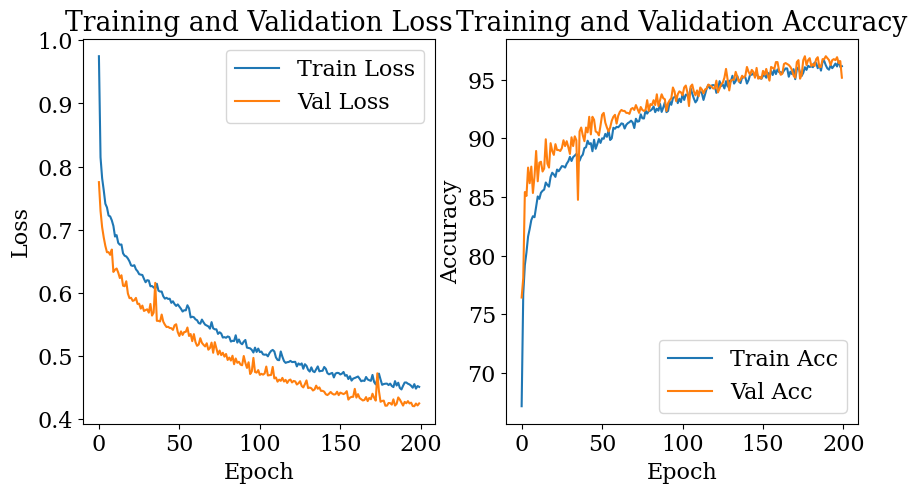

Finished Training


In [238]:
plt.rcParams['text.usetex'] = False

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

save_path = os.path.join("./bs_16_lr_0.0001_10th_exr_tr1_nc_4_acc.png")
plt.savefig(save_path)

plt.show()

print('Finished Training')

PATH = './mymodel_bs_16_lr_0.0001_10th_exr_tr1_nc_4.pth'
torch.save(net.state_dict(), PATH)


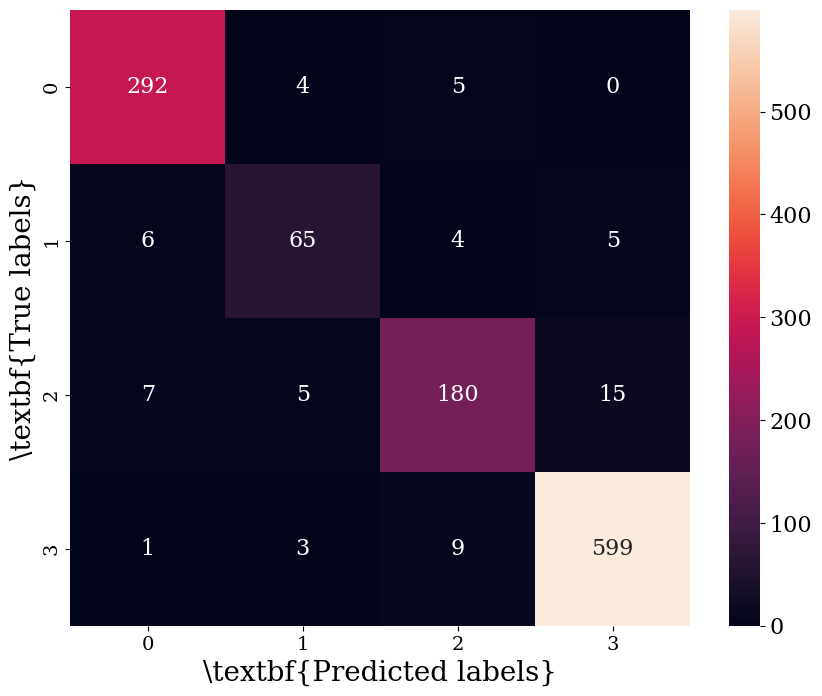

              precision    recall  f1-score   support

           0      0.844     0.812     0.828        80
           1      0.954     0.970     0.962       301
           2      0.909     0.870     0.889       207
           3      0.968     0.979     0.973       612

    accuracy                          0.947      1200
   macro avg      0.919     0.908     0.913      1200
weighted avg      0.946     0.947     0.946      1200



In [ ]:
import random

PATH = './mymodel_bs_16_lr_0.0001_10th_exr_tr1_nc_4.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)

all_predicted = []
all_labels = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels, t_p_values = data[0].to(device), data[1].to(device), data[2].to(device)
        inputs = inputs.unsqueeze(1)

        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        all_predicted.extend(predicted.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy()) 

conf_matrix = confusion_matrix(all_labels, all_predicted)

conf_matrix[[0, 1], :] = conf_matrix[[1, 0], :]  
conf_matrix[:, [0, 1]] = conf_matrix[:, [1, 0]] 

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'  
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="g", cbar=True)

plt.xlabel(r"\textbf{Predicted labels}", fontsize=20)  # LaTeX bold text
plt.ylabel(r"\textbf{True labels}", fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

save_path = os.path.join("./conf_tr1_nc_4.pdf")
plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)

plt.show()

from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predicted, digits=3))


In [240]:
PATH = './mymodel_bs_16_lr_0.0001_10th_exr_tr1_nc_4.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=256, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
from collections import defaultdict, Counter
import torch
import torch.nn.functional as F
import numpy as np
import scipy.io
import time

def most_common(lst):
    return Counter(lst).most_common(1)[0][0]

grouped_predictions = defaultdict(list)
grouped_confidences = defaultdict(list)  

net.eval()
prediction_time = 0
i = 0
with torch.no_grad():
    for filename, image_data in testing_images.items(): 
        base_filename = filename.split('-t_')[0]

        if isinstance(image_data, np.ndarray):  
            
            image = np.log(image_data + 1)
            image = (image - train_mean) / train_std  

            input_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)  

            start_time = time.time()

            outputs = net(input_tensor)

            end_time = time.time()  
            prediction_time = prediction_time + end_time - start_time  

            _, predicted = torch.max(outputs.data, 1)

            probabilities = F.softmax(outputs, dim=1)

            confidence_score = probabilities[0, predicted.item()].item()

            grouped_predictions[base_filename].append(predicted.item())
            grouped_confidences[base_filename].append(confidence_score)
            i += 1

print(f'Prediction time on average: {prediction_time/855:.6f} seconds')

final_predictions = {}
final_confidences = {}
for base_filename, preds in grouped_predictions.items():
    most_common_pred = most_common(preds)
    final_predictions[base_filename] = most_common_pred + 1  

    confidence_list = [conf for pred, conf in zip(grouped_predictions[base_filename], grouped_confidences[base_filename]) if pred == most_common_pred]
    final_confidences[base_filename] = np.mean(confidence_list)

file_names = list(final_predictions.keys())
predictions = list(final_predictions.values())
all_preds_list = [np.array(grouped_predictions[filename]) for filename in file_names]
confidence_list = [final_confidences[filename] for filename in file_names]  

file_names = np.array(file_names, dtype=object)
predictions = np.array(predictions)
confidence_list = np.array(confidence_list)  

data_to_save = {
    'file_names': file_names,
    'predictions': predictions,
    'confidence_scores': confidence_list,  
    'all_predictions': all_preds_list
}

scipy.io.savemat('./clustering_res/tr_1/predictions_nc_4.mat', data_to_save)

print("Predictions and confidence scores saved successfully.")


Prediction time on average: 0.000315 seconds
Predictions and confidence scores saved successfully.
